In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from textblob import TextBlob
from  sklearn.feature_extraction.text import CountVectorizer
import pdb 
from nltk.stem import *
from nltk.corpus import stopwords
import re
import string
from collections import Counter
#from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction import text 
from wordcloud import WordCloud

In [10]:
data1 = pd.read_csv("drugsComTrain_raw.tsv",sep='\t')

In [11]:
data2 = pd.read_csv("drugsComTest_raw.tsv",sep='\t')

In [86]:
data = pd.concat([data1,data2])
data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [87]:
data.shape

(215063, 7)

In [88]:
def aggregateReviewsByCondition(data): 
   
    variable = list(data.condition.unique())
    conditionList , drugnameList,chunkList, ratingList,usefulCountList = [],[],[],[],[]
    
    #iterating through a condition
    for i in range(len(variable)):        
        conditionVariable= data.loc[data['condition']==variable[i]]
        #iterating through each drug in the condition
        for t in list(conditionVariable.drugName.unique()):
            drugname = conditionVariable.loc[conditionVariable['drugName']==t]
            rating = data.rating[(data.drugName==t) & (data.condition ==variable[i])].mean()
            usefulcount = data.usefulCount[(data.drugName==t) & (data.condition ==variable[i])].sum()
            #appending each review of each drug under one condition into one big chunk of text
            chunk = ''.join(drugname.review)
            #Storing my data into a list and then a dictionary for my dataframe
            conditionList.append(variable[i])
            drugnameList.append(t)
            chunkList.append(chunk)
            ratingList.append(round(rating,2))
            usefulCountList.append(usefulcount)
    final_dict ={"Conditions":conditionList,"drugNames":drugnameList,"reviews":chunkList,"averageRating":ratingList,"counts":usefulCountList}
    aggregated_df = pd.DataFrame(final_dict)
    return(aggregated_df)

In [89]:
def removeSpecialCharacters(data):
    
    clean = data.reviews
    clean = clean.str.lower()
    clean = clean.str.replace('\[.,*?\]', '')
    clean = clean.str.replace('\w*\d\w*', '')
    clean = clean.str.replace('[%s]' % re.escape(string.punctuation), '')
    clean = clean.str.replace('\n','')
    clean = clean.str.replace('[‘’“”…]', '')
    return clean


In [90]:
stemmer = PorterStemmer()    
lemmatizer = WordNetLemmatizer()
def word_stemmer(text):
    stem_text = "".join([stemmer.stem(i) for i in text])
    return stem_text 


def word_lemmatizer(text):
    lem_text = "".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text


In [91]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words


In [46]:
def createDTM(data,stopword):
 
    cv = CountVectorizer(stop_words=stopword)

    data_cv = cv.fit_transform(data.reviews)
        #temp[i]= data_cv
        
    data_dtm =pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
    data_info = data[['Conditions','drugNames']]
    #data_merged = pd.concat([data_info,test],axis=1)
    
    data_dtm.index = pd.MultiIndex.from_frame(data_info)
    return data_dtm

In [92]:
combined_data = aggregateReviewsByCondition(data)

combined_data.head(10)

,Conditions,drugNames,reviews,averageRating,counts
0,Left Ventricular Dysfunction,Valsartan,"""It has no side effect, I take it in combinati...",9.50,58
1,Left Ventricular Dysfunction,Coreg,"""My heart rate was speeding up to the point I ...",8.83,204
2,Left Ventricular Dysfunction,Metoprolol,"""Very nice, helped heart, now do sports easy, ...",6.50,25
3,Left Ventricular Dysfunction,Diovan,"""It has no side effect, I take it in combinati...",9.50,58
4,Left Ventricular Dysfunction,Carvedilol,"""My LVEF was about 20 when I started on Coreg ...",9.12,254
5,Left Ventricular Dysfunction,Enalapril,"""This medication worked great for me as far as...",6.67,41
6,Left Ventricular Dysfunction,Toprol-XL,"""Very nice, helped heart, now do sports easy, ...",8.00,9
7,Left Ventricular Dysfunction,Benazepril,"""It&#039;s working fine for me in controlling ...",8.00,18
8,Left Ventricular Dysfunction,Vasotec,"""This medication worked great for me as far as...",9.00,7
9,ADHD,Guanfacine,"""My son is halfway through his fourth week of ...",5.74,7870


In [ ]:
combined_data.tail(10)

In [ ]:
print(combined_data[combined_data['Conditions'].str.contains("users found this")].shape)
print(combined_data[~combined_data['Conditions'].str.contains("Not Listed / Othe")].shape)

In [49]:
combined_data = combined_data[~combined_data['Conditions'].str.contains("users found this")] 
print(combined_data.shape)
combined_data = combined_data[~combined_data['Conditions'].str.contains("Not Listed / Othe")] 
print(combined_data.shape)
#quick look at the data
combined_data.head(10)


,Conditions,drugNames,reviews,averageRating,counts
9431,Tympanostomy Tube Placement Surgery,Ciprofloxacin,"""No infection after tube removal from our 11 y...",7.0,1
9432,Pulmonary Edema,Furosemide,"""Right after surgery, I had a fever, confusion...",9.0,17
9433,Mantle Cell Lymphoma,Ibrutinib,"""For the first few months, I experienced some ...",10.0,5
9434,Mantle Cell Lymphoma,Imbruvica,"""For the first few months, I experienced some ...",10.0,5
9436,"Lyme Disease, Erythema Chronicum Migrans",Azithromycin,"""For Lyme symptoms (which vary over months) I&...",8.0,4
9438,Renal Tubular Acidosis,Potassium citrate,"""Minutes after taking this my lips started to ...",5.5,2
9439,Yellow Fever Prophylaxis,Yellow fever vaccine,"""I had yellow fever vaccination three weeks ag...",5.0,2
9440,Acute Otitis Externa,Ciprofloxacin,"""These drops ruined my hearing I developed hea...",1.0,3
9441,Steroid Responsive Inflammatory Conditions,Fluorometholone,"""I thought I had too much wine or was losing i...",8.0,0
9444,Pertussis Prophylaxis,Clarithromycin,"""So my 10 year old daughter has tested positiv...",5.0,1


In [ ]:
combined_data.tail(10)

In [50]:
combined_data.reviews= removeSpecialCharacters(combined_data)
#both lemmatizer and stemmer had almost same impact on cleaning
#process so running either of any would do just fine
combined_data.reviews = combined_data.reviews.apply(lambda x: word_stemmer(x))
#combined_data.chunk = combined_data.chunk.apply(lambda x: word_lemmatizer(x))

In [51]:
new_stop_words =['im','like', 'just','ive', 'forwardyesterday', 'says','mei'
 ,'forwardthis', 'forwas','forwards', 'forwhat',
 'forwhen', 'forwardmy','forwhile','did', 'took','wont','uti',
'forwish','forworked','forwardmethadone', 'іt','didnt','let','aa','aaa','aaaaa',
'zzzzzzzzthe','zzz','zzzzz', 'zzzzzzzzif','aaaaand', 'aaaaargmy', 'aaaand','aaahhi', 'aaand',
 'aaddthis', 'aafter', 'aai', 'aam', 'aamp', 'aampb', 'aampd',
 'aampe', 'aampee','aana', 'aap','aampeon', 'zzzzap','aampethe','abacavirlamivudinenevirapine',
 'aaps','aarp','aatd','ab','abbvie','taking']
stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)
test = createDTM(combined_data,stop_words) 
test = test.transpose()

In [52]:
def topwords(data,n):
    top_dict = {}
    for c in data.columns:
        top = data[c].sort_values(ascending=False).head(n)
        top_dict[c]= list(zip(top.index,top.values))

    return top_dict

In [53]:
top_word = topwords(test,30)

i =0
for drugName, top_words in top_word.items():
    if i !=14: #to visualize a hand few of the result 
        print(drugName)
        print(', '.join([word for word, count in top_words[0:14]]))
        print('---')
        i+=1
#this would be easily visualized using  word cloud later on

('Left Ventricular Dysfunction', 'Valsartan')
issues, daily, edema, mg, oili, norvasc, effect, combination, medicine, diovan, relief, fish, bystolic, forwardim
---
('Left Ventricular Dysfunction', 'Coreg')
heart, medicine, coreg, left, knees, started, used, improved, lvef, better, daily, mg, month, good
---
('Left Ventricular Dysfunction', 'Metoprolol')
mg, diltiazem, days, pvcs, er, symptoms, helped, getting, pulmonary, ativan, suffered, share, steadily, clots
---
('Left Ventricular Dysfunction', 'Diovan')
issues, daily, edema, mg, oili, norvasc, effect, combination, medicine, diovan, relief, fish, bystolic, forwardim
---
('Left Ventricular Dysfunction', 'Carvedilol')
ef, coreg, heart, medicine, started, drug, day, left, knees, forget, better, lvef, pressure, attack
---
('Left Ventricular Dysfunction', 'Enalapril')
days, weeks, heart, medication, years, coughing, fluids, son, pancreatitis, remodeling, angioedema, dizziness, hope, works
---
('Left Ventricular Dysfunction', 'Toprol-XL')

In [55]:
# pull out the top 30 words for each condition
words = []

for Condition in test.columns:
    top = [word for (word, count) in top_word[drugName]]
    
    for t in top:
        words.append(t)
#This displays the number of unique rows (condition and drugname)  where each word was used.
Counter(words).most_common()

[(word,count) for word, count in Counter(words).most_common()]
#Wordcloud can be used to visualize how customer perceive the effectiveness
#of a medication for each medication
wc = WordCloud(stopwords=stop_words,
                       background_color='white',
                       colormap='Dark2',
                       max_font_size=300,
                       max_words=30,
                       random_state=42)
combined_data[['Conditions','drugNames']]
#Use this to randomly get a condition and drugname
search =combined_data.loc[np.random.randint(0,combined_data.shape[0]),['Conditions','drugNames']]

condition =search[0]
drugname=search[1]

Report on Thorazine for Mania


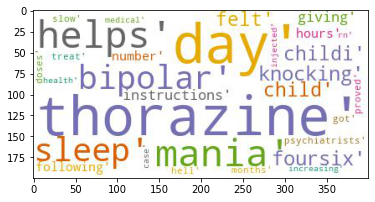

Average Rating of  : [5.5]


Found Useful To(persons) : [38]


List of other drugs also for Mania: ['Depakote', 'Divalproex sodium', 'Lithium', 'Stavzor', 'Risperidone', 'Haldol', 'Chlorpromazine', 'Depakote ER', 'Haloperidol', 'Risperdal', 'Depakote Sprinkles', 'Valproic acid']  


Best medication  based on Average rating : Stavzor


best Medication by number of person(s) that found it useful: Divalproex sodium



In [60]:
print("Report on {0} for {1}".format(drugname,condition))
wcdata = combined_data.reviews[(combined_data.Conditions == condition) & (combined_data.drugNames==drugname)]
wc_topword= top_word[(condition,drugname)]
wc.generate(str(wc_topword))
wc.to_file('wc.jpeg')
plt.show
plt.show('wc.jpeg')
img = mpimg.imread('wc.jpeg')
imgplot = plt.imshow(img)
plt.show()
wc_topword= top_word[(condition,drugname)]
wc.generate(str(wc_topword))


'''
You can easily see a high correlation between  (Number of people 
that found it useful and average rating) and positivity or negativity of 
words found in the word cloud
'''
#Note that max rating is a 10.
realdata = data[['drugName', 'condition','rating','usefulCount']]
realdata = realdata[data.condition == condition]

alldrugs = combined_data[(combined_data.Conditions == condition)]
requesteddrug = combined_data[(combined_data.Conditions ==condition) & (combined_data.drugNames == drugname)]
relateddrugs =  combined_data[(combined_data.Conditions ==condition) & (combined_data.drugNames != drugname)]
max_average_rating = list(alldrugs.drugNames[alldrugs.averageRating == alldrugs.averageRating.max()])[0]
max_usefulTo =list(alldrugs.drugNames[alldrugs.counts == alldrugs.counts.max()])[0]

print("Average Rating of  : {0}\n".format(list(requesteddrug.averageRating))+'\n\n'+
"Found Useful To(persons) : {0}\n".format(list(requesteddrug.counts))+'\n\n'+
"List of other drugs also for {1}: {0}  \n".format(list(relateddrugs.drugNames.unique()),condition)+'\n\n'+
"Best medication  based on Average rating : {0}\n".format(max_average_rating)+'\n\n'+
"best Medication by number of person(s) that found it useful: {0}\n".format(max_usefulTo))

In [61]:
def is_positive(reviews: str) -> bool:
    return sia.polarity_scores(reviews)["compound"] > 0

In [64]:
import nltk

nltk.download([
 "names",
 "stopwords",
 "averaged_perceptron_tagger",
 "vader_lexicon",
 "punkt"
])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\smvijaykumar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\names.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smvijaykumar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\smvijaykumar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\smvijaykumar\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smvijaykumar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [75]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
combined_data['is_positive'] = [is_positive(review) for review in combined_data.reviews]

In [84]:
print(len(combined_data[combined_data['is_positive'] == False]))

4754


In [78]:
from icecream import ic
ic(combined_data.shape)
ic(data1.shape)
ic(data2.shape)

ic| combined_data.shape: (8333, 6)
ic| data1.shape: (161297, 7)
ic| data2.shape: (53766, 7)


(53766, 7)